<a href="https://colab.research.google.com/github/mahb97/Historiographic-Drift-Simulator/blob/main/heardyousay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Baseline window = 20 (offset=0) — slope=0.438518, sign=1
Under-flow: 0.0% of (window, offset) combos flip the trend relative to baseline.


,window,offset,slope,sign
0,5,0,0.476707,1
1,5,1,0.417757,1
2,5,2,0.452580,1
3,5,3,0.437641,1
4,5,4,0.456941,1
5,10,0,0.493486,1
6,10,1,0.385591,1
7,10,2,0.446116,1
8,10,3,0.388427,1
9,10,4,0.381631,1


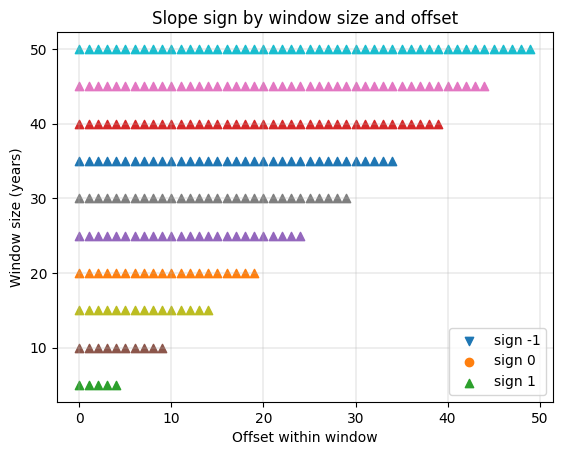

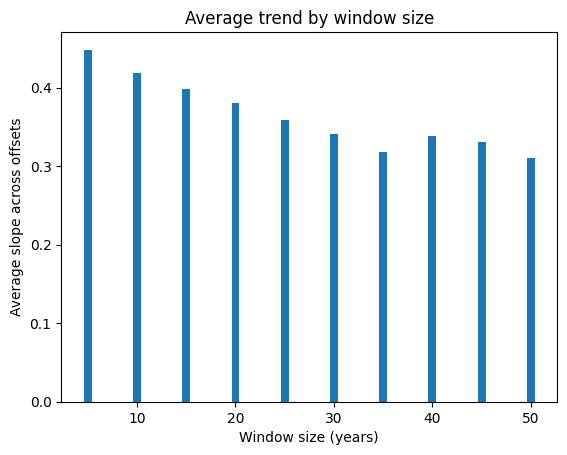

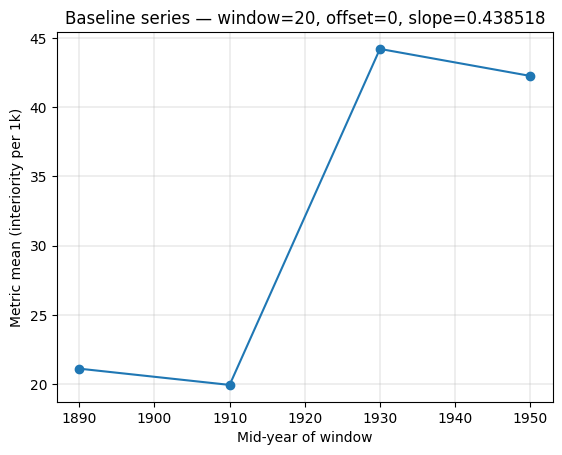

In [1]:
# Historiographic Drift Simulator
# I'm not here to “discover” history; I'm here to expose how your bins gaslight your trends.
# Softmax can sit this one out.

# the wholesome part, before committing methodological crimes
import math, itertools, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_rows', 100)

# CONFIG touch this if you must
USE_DEMO = True          # True => use the cooked demo set; False => BYO CSV (year,text)
BASELINE_WINDOW = 20     # our “official story” bin width. the rest will try to overthrow it.
WINDOW_SIZES = list(range(5, 55, 5))  # the parade of bin sizes (5y..50y)

# DATA LOADING it’s either soup we made or soup you brought
if USE_DEMO:
    # synthesize a barely-upward trend with a mid-period dip
    # so the sign will flip depending on how it's sliced. methodological jump-scare.
    rng = np.random.default_rng(7)
    years = np.arange(1880, 1951)
    baseline = 0.02 * (years - years.min())                       # tiny secular rise
    noise = rng.normal(0, 0.3, size=len(years))                   # chaos, as a treat
    dip = -1.2 * np.exp(-0.5*((years-1910)/5)**2)                 # the “oh no” in the middle
    latent = baseline + noise + dip

    # forge texts: a crude mapping from latent metric to first-person rate
    texts = []
    for y, m in zip(years, latent):
        rate = max(0.0, min(0.06, 0.02 + 0.015*m))                # cap the nonsense
        length = rng.integers(80, 160)
        n_fp = rng.binomial(length, rate)                         # “I”-bombing
        n_other = length - n_fp
        txt = " ".join(["I"]*n_fp + ["stone"]*n_other)            # medieval tokenizer left the building
        texts.append((y, txt))
    df = pd.DataFrame(texts, columns=["year","text"])
else:
    from google.colab import files; up = files.upload()
    fname = list(up.keys())[0]
    df = pd.read_csv(fname)
    raise RuntimeError("Set USE_DEMO=True or implement your own CSV load (columns: year,text).")

# METRIC (pick your poison; start with ‘interiority’ = first-person per 1k tokens)
FIRST_PERSON = set("i me my mine myself we us our ours ourselves".split())

def tokenize(s):
    # tokenizer so minimal it’s practically a provocation
    return [t.strip("'\".,;:!?()[]{}<>-") for t in s.lower().split() if t.strip()]

def interiority_per_1k(text: str) -> float:
    toks = tokenize(text)
    if not toks:
        return 0.0
    fp = sum(1 for t in toks if t in FIRST_PERSON)
    return 1000.0 * fp / len(toks)

df["metric"] = df["text"].astype(str).apply(interiority_per_1k)

# choose bins, shift them, watch history change its mind
def aggregate_by_windows(frame: pd.DataFrame, window: int, offset: int) -> pd.DataFrame:
    yrs = frame["year"].astype(int)
    y_min, y_max = yrs.min(), yrs.max()
    # start boundary that respects the offset. the calendar did not consent to this, but here we are.
    start = y_min - ((y_min - offset) % window)
    bins = []
    cur = start
    while cur <= y_max:
        bins.append((cur, cur + window))  # [lo, hi)
        cur += window
    rows = []
    for lo, hi in bins:
        mask = (yrs >= lo) & (yrs < hi)
        if not mask.any():
            continue
        metric_mean = frame.loc[mask, "metric"].mean()
        mid = (lo + hi) / 2.0
        rows.append((mid, metric_mean, lo, hi))
    return pd.DataFrame(rows, columns=["mid_year","metric_mean","lo","hi"])

def linear_slope(x, y):
    x = np.asarray(list(x)).reshape(-1, 1)
    y = np.asarray(list(y))
    if len(x) < 2:
        return np.nan   # no line, no vibes
    model = LinearRegression()
    model.fit(x, y)
    return float(model.coef_[0])

def slope_for_window_offset(frame, window, offset):
    agg = aggregate_by_windows(frame, window, offset)
    s = linear_slope(agg["mid_year"], agg["metric_mean"])
    return s, agg

# the “official story”
sign = lambda s: (1 if s > 0 else (-1 if s < 0 else 0))
base_slope, base_agg = slope_for_window_offset(df, BASELINE_WINDOW, 0)
base_sign = sign(base_slope)

# throw offsets at the wall and see which ones betray
results = []
for w in WINDOW_SIZES:
    for off in range(w):  # sweep every offset because we are thorough AND petty
        s, _ = slope_for_window_offset(df, w, off)
        results.append({"window": w, "offset": off, "slope": s, "sign": sign(s)})
res = pd.DataFrame(results)

# UNDER-FLOW
if base_sign == 0:
    disagree_mask = (res["sign"] != 0)  # if baseline is “meh”, any opinion is mutiny
else:
    disagree_mask = (res["sign"] == -base_sign)
under_flow = 100.0 * disagree_mask.mean()

print(f"Baseline window = {BASELINE_WINDOW} (offset=0) — slope={base_slope:.6f}, sign={base_sign}")
print(f"Under-flow: {under_flow:.1f}% of (window, offset) combos flip the trend relative to baseline.")
display(res.head(10))

# PLOTS (matplotlib, default styles; I'm not here to art-direct your existential dread

# “Heatmap-ish” sign map: offset on x, window size on y, markers for sign
plt.figure()
for w in WINDOW_SIZES:
    sub = res[res["window"] == w]
    xs = sub["offset"].values
    ys = np.full_like(xs, w, dtype=float)
    ms = sub["sign"].values
    for sgn, marker in [(-1, "v"), (0, "o"), (1, "^")]:
        mask = (ms == sgn)
        plt.scatter(xs[mask], ys[mask], marker=marker,
                    label=f"sign {sgn}" if w == WINDOW_SIZES[0] else None)
plt.xlabel("Offset within window")
plt.ylabel("Window size (years)")
plt.title("Slope sign by window size and offset")
plt.grid(True, linewidth=0.3)
plt.legend()
plt.show()

# Average slope by window size (because if you average hard enough, you can vibe-check anything)
avg_by_w = res.groupby("window")["slope"].mean().reset_index()
plt.figure()
plt.bar(avg_by_w["window"], avg_by_w["slope"])
plt.xlabel("Window size (years)")
plt.ylabel("Average slope across offsets")
plt.title("Average trend by window size")
plt.show()

# Example series for the baseline (the establishment view)
s, agg = slope_for_window_offset(df, BASELINE_WINDOW, 0)
plt.figure()
plt.plot(agg["mid_year"], agg["metric_mean"], marker="o")
plt.xlabel("Mid-year of window")
plt.ylabel("Metric mean (interiority per 1k)")
plt.title(f"Baseline series — window={BASELINE_WINDOW}, offset=0, slope={s:.6f}")
plt.grid(True, linewidth=0.3)
plt.show()

# HACK - swap the metric to something else
# e.g., modal verbs per 1k, cognitive verbs per 1k, sentiment (lol), etc.
# define your_metric(text) -> float, then set df["metric"] = df["text"].apply(your_metric)
# re-run from “WINDOWING” down. congrats b.
